In [ ]:
import pandas as pd
import h5py 
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
#from perso_utils import get_names, load_image

ImportError: cannot import name 'get_names' from 'perso_utils' (/Users/tomw/Documents/MVA/Internship/Cambridge/Code/Cambridge/DINOSim/src/napari_dinosim/personalized_pipeline/perso_utils.py)

In [ ]:
#TODO: For LINUX:
dataset_path = '/home/tomwelch/Cambridge/Datasets/neurotransmitter_data' #@param {type:"string"}

#TODO: For MAC:
#dataset_path = '/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/neurotransmitter_data'

dates = glob(os.path.join(dataset_path, '*'))
neurotransmitters = list(map(lambda x: os.path.basename(os.path.normpath(x)), glob(os.path.join(dates[0], '*')))) #@param {type:"string"} 

In [ ]:
def get_direction(path):
    with h5py.File(path) as f:
        pre, post = f['annotations/locations'][:]/8
        x_pre, y_pre, z_pre = pre[0].astype(int), pre[1].astype(int), pre[2].astype(int)
        x_post, y_post, z_post = post[0].astype(int), post[1].astype(int), post[2].astype(int)
        direction_vector = np.array([x_pre - x_post, y_pre - y_post, z_pre - z_post])
        main_axis = np.argmax(np.abs(direction_vector))
        norm = np.linalg.norm(direction_vector)
        coord_list = ['x','y','z']
        return coord_list[main_axis], norm

In [ ]:
def statistics():
    all_stats = []
    for date in dates:
        for neuro in neurotransmitters:
            neuro_stats = []
            path_list = glob(os.path.join(date, neuro, '*.hdf*'))
            path_list.sort()
            for path in path_list:
                _, norm = get_direction(path)
                neuro_stats.append(norm)
            all_stats.append(np.mean(neuro_stats))
    stats = []
    nb_neuro = len(neurotransmitters)
    for k in range(nb_neuro):
        stats.append([np.mean(all_stats[k]+all_stats[k+nb_neuro]), neurotransmitters[k].capitalize()])
    plt.figure(figsize=(12,7), dpi=300)
    plt.bar([x[1] for x in stats], [x[0] for x in stats])
    plt.ylabel('Mean Pre-Post Distance')
    plt.title('Mean Pre-Post Distance by Neurotransmitter')
    mean = np.mean([x[0] for x in stats])
    plt.axhline(mean, label=f'{mean: .1f}', color='red', linestyle='dashed')
    plt.legend()

In [ ]:
def get_cropped_image(path):
    main_axis, norm = get_direction(path)
    norm = round(norm)
    with h5py.File(path) as f:
        pre, _ = f['annotations/locations'][:]/8
        x, y, z = [pre[i].astype(int) for i in range(3)]
        
        slice_volume = f['volumes/raw'][:]
        
        # Get volume dimensions to ensure we don't go out of bounds
        dim_x, dim_y, dim_z = slice_volume.shape
        
        if main_axis == 'x':
            y1, y2 = max(0, y-norm), min(dim_y, y+norm+1)
            z1, z2 = max(0, z-norm), min(dim_z, z+norm+1)
            return slice_volume[x, y1:y2, z1:z2], slice_volume[x,:,:] 
        elif main_axis == 'y':
            x1, x2 = max(0, x-norm), min(dim_x, x+norm+1)
            z1, z2 = max(0, z-norm), min(dim_z, z+norm+1)
            return slice_volume[x1:x2, y, z1:z2], slice_volume[:,y,:]
        else:  # main_axis == 'z'
            x1, x2 = max(0, x-norm), min(dim_x, x+norm+1)
            y1, y2 = max(0, y-norm), min(dim_y, y+norm+1)
            return slice_volume[x1:x2, y1:y2, z], slice_volume[:,:,z]

In [ ]:
def display_cropped_image(n):
    for date in dates:
            for neuro in neurotransmitters:
                fnames = glob(os.path.join(date, neuro, '*.hdf*'))
                fnames.sort()
                for file in fnames[:n]:
                    img_c, img_o = get_cropped_image(file)
                    plt.figure(figsize=(12,7), dpi=300)
                    plt.suptitle(f'{neuro.capitalize()}')
                    plt.subplot(121)
                    plt.imshow(img_o, cmap='gray')
                    plt.title(f'Original image')
                    plt.subplot(122)
                    plt.imshow(img_c, cmap='gray')
                    plt.title('Cropped image')
                    plt.show()

In [ ]:
statistics()

In [8]:
from setup import model, Trans, umap, torch, tqdm, np, px, PCA, os, glob
from perso_utils import get_processed_image, get_fnames

/home/tomwelch/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Device: cpu


Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


In [21]:
def get_embeddings(batch_size=1):

    transform = Trans.Compose([
        Trans.ToTensor(),
        Trans.Resize((224, 224)),
        Trans.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
        ])

    fnames, labels_l = get_fnames()
    labels = labels_l[:100]
    latent, img_batch = [], []
    
    for file in tqdm(fnames[:100], desc='Computing embeddings'):
        try:
            # Get and process the image
            img_c = get_processed_image(file)[3][0,...,0]
            img_rgb = np.stack([img_c, img_c, img_c], axis=2)
            img_tensor = transform(img_rgb).unsqueeze(0)  # Add batch dimension
            img_batch.append(img_tensor)
            
            # Process batch when we reach batch_size
            if len(img_batch) == batch_size:
                batch_tensor = torch.cat(img_batch, dim=0)
                with torch.no_grad():
                    features = model(batch_tensor)
                    latent.append(features.cpu().numpy())
                img_batch = []  # Clear the batch
                
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue

    # Process any remaining images in the last batch
    if img_batch:
        batch_tensor = torch.cat(img_batch, dim=0)
        with torch.no_grad():
            features = model(batch_tensor)
            latent.append(features.cpu().numpy())

    # Concatenate all batches of features
    if not latent:
        return None, labels
    return np.stack(latent), labels

In [22]:
e, l = get_embeddings()

Computing embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

Computing embeddings: 100%|██████████| 100/100 [00:05<00:00, 19.91it/s]


In [27]:
pca = PCA(n_components=25)
reduced_features = pca.fit_transform(e.squeeze())
print(reduced_features.dtype)

float32


In [28]:
reducer = umap.UMAP(
            n_neighbors=5,
            min_dist=0.01,
            n_components=2,
            metric='cosine',
            )
embedding = reducer.fit_transform(reduced_features)
embedding.dtype

dtype('float32')

In [8]:
def get_fnames():
    files, labels = [], []
    for date in dates:
        for neuro in neurotransmitters:
            fnames = glob(os.path.join(date, neuro, '*.hdf*'))
            fnames.sort()
            files.append(fnames)
            labels.append([neuro.capitalize() for _ in range(len(fnames))])
    return list(zip(np.concatenate(files), np.concatenate(labels)))

#----------------------------------------------------------------------------------------------------------------------------------------------

def load_image(path):
    with h5py.File(path) as f:
        pre, post = f['annotations/locations'][:]/8
        x, y, z = pre[0].astype(int), pre[1].astype(int), pre[2].astype(int)
        slice_volume = f['volumes/raw'][:][np.newaxis,:,:,z]
        return slice_volume, x, y

In [11]:
dataset_path = '/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/neurotransmitter_data'

dates = glob(os.path.join(dataset_path, '*'))
neurotransmitters = list(map(lambda x: os.path.basename(os.path.normpath(x)), glob(os.path.join(dates[0], '*')))) #@param {type:"string"} 


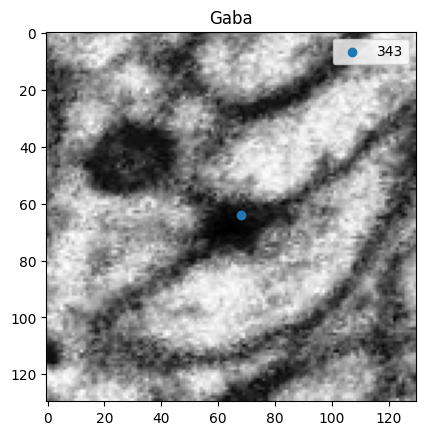

In [23]:
def open_image():
    i = 343
    file, label = get_fnames()[i]
    img, x, y = load_image(file)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.scatter(x,y, label=str(i))
    plt.title(label)
    plt.legend()
    plt.show()
open_image()

In [29]:
good_idx = [5, 7, 8, 10, 13, 300, 310, 316, 337, 343, 611, 614, 622, 623, 631, 901, 903, 905, 907, 912, 1210, 1211, 1213, 1220, 1221, 1500, 1507, 1509, 1510, 1514, 1517]
files = get_fnames()
dataset = [files[idx][0] for idx in good_idx]
for i in range(0, len(good_idx), 5):
        data = dataset[i:i+5]
datas = [dataset[i:i+5] for i in range(0, len(good_idx), 5)]

In [34]:
datas[6]

[np.str_('/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/neurotransmitter_data/sylee_neurotrans_cubes_24Mar2025/acetylcholine/acetylcholine_12563-12693_y28596-28726_z13006-13136_5813063587.hdf')]

In [35]:
len(good_idx)

31

In [4]:
k=5
_MITO_labels = [['MITO_Acetylcholine' for _ in range(k)], 
                   ['MITO_Acetylcholine' for _ in range(k)], 
                   ['MITO_Dopamine' for _ in range(k)], 
                   ['MITO_Dopamine' for _ in range(k)], 
                   ['MITO_GABA' for _ in range(k)], 
                   ['MITO_GABA' for _ in range(k)], 
                   ['MITO_Glutamate' for _ in range(k)], 
                   ['MITO_Glutamate' for _ in range(k)], 
                   ['MITO_Octapamine' for _ in range(k)], 
                   ['MITO_Octapamine' for _ in range(k)], 
                   ['MITO_Serotonin' for _ in range(k)], 
                   ['MITO_Serotonin' for _ in range(k)]]
    
MITO_labels = sum(_MITO_labels, [])
MITO_labels

['MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Acetylcholine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_Dopamine',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_GABA',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Glutamate',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Octapamine',
 'MITO_Serotonin',
 'MITO_Serotonin',
 'MITO_Serotonin',
 'M